In [ ]:
# Initial exploratory code to read ROOT data
# optimized code follows in later cells

import numpy as np
import uproot
import awkward as ak

root_folder = "/home/hep/at3722/root-obj-perf/data/hhbbbb"
file_name = "data_0.root"
file_path = f"{root_folder}/{file_name}"
print(file_path)

tree = uproot.concatenate(file_path + ":Events", library="ak", max_num_elements=5000)
branches = tree

# print(tree.keys())
idx = 0
branches["GenPart_pdgId"][idx], branches["GenPart_genPartIdxMother"][idx]

In [ ]:
def find_mother(particle_idx, all_mothers, particle_ids, target_ids, particles_seen=[]):
    mother_idx = all_mothers[particle_idx]
    while mother_idx != -1:
        mother_id = particle_ids[mother_idx]
        if mother_id in target_ids:
            return mother_idx
        mother_idx = all_mothers[mother_idx]
        print(mother_idx)
    return -1


def find_mother_recursive(particle_idx, all_mothers, particle_ids, target_ids, particles_seen=[]):
    mother_idx = all_mothers[particle_idx]
    if mother_idx == -1:
        return -1
    mother_id = particle_ids[mother_idx]
    if mother_id in target_ids and mother_id != particle_ids[particle_idx]:
        return mother_idx
    if mother_idx in particles_seen:
        return -1
    if mother_id not in target_ids:
        return mother_idx
    particles_seen.append(mother_idx)
    # print(particles_seen)
    return find_mother_recursive(mother_idx, all_mothers, particle_ids, target_ids, particles_seen)


In [ ]:
# Loop over all events and find b quarks from Higgs or Tau mothers

# target_ids = {25, 15} # Higgs and Tau mothers
target_ids = {25} # Higgs mothers only

all_b_quarks = []
for single_event in branches:
    particle_ids = single_event["GenPart_pdgId"]
    all_mothers = single_event["GenPart_genPartIdxMother"]

    b_idxs = ak.where(abs(particle_ids) == 5)[0] # for b quarks
    b_idxs_loop = []
    b_mom_idxs = []

    particles_seen = []
    # for i, pid in enumerate(single_event["GenPart_pdgId"]): # update this to just loop over b quark indices
    for i in b_idxs:
        pid = particle_ids[i]
        if abs(pid) == 5: # for b quarks
            mom_idx = find_mother_recursive(i, all_mothers, particle_ids, target_ids, particles_seen=particles_seen)
            mom_pid = particle_ids[mom_idx]
            # print(f"Checking b idx: {i}, b pid: {pid}, mom idx: {mom_idx}, mom pid: {mom_pid}, particles seen: {particles_seen}")
            if mom_idx != -1 and mom_pid in target_ids:
                b_idxs_loop.append(i)
                b_mom_idxs.append(mom_idx)
                particles_seen.append(i)


    # print("\nB hadron indices (ak.where):", b_idxs)
    # print("B hadron indices (loop):", b_idxs_loop)
    # print("B hadron mother indices (loop):", b_mom_idxs)

    # print("Particles seen during search:", particles_seen)

    all_b_quarks.append(ak.Array([b_idxs_loop, b_mom_idxs]))


all_b_quarks = ak.Array(all_b_quarks)
all_b_quarks[0:2, :, :]  # first two events, particle_idx/mom_idx <-> 0/1, b quark num


In [ ]:
from collections import defaultdict
single_event = branches[0]

higgs_id = 25
all_higgs_decays = defaultdict(list)

for event_idx, single_event in enumerate(branches):
    particle_ids = single_event["GenPart_pdgId"]
    all_mothers = single_event["GenPart_genPartIdxMother"]
    higgs_idxs = ak.where(abs(particle_ids) == higgs_id)[0]

    higgs_is_mom = defaultdict(list)

    for i, pid in enumerate(particle_ids):
        mom_idx = find_mother_recursive(i, all_mothers, particle_ids, {higgs_id}, particles_seen=[])
        mom_pid = particle_ids[mom_idx]
        if mom_idx != -1 and abs(mom_pid) == higgs_id:
            # print(f"Particle idx: {i}, pid: {pid}, mom idx: {mom_idx}, mom pid: {mom_pid}")
            higgs_is_mom[mom_idx].append(i)

    all_higgs_decays[event_idx] = higgs_is_mom

In [ ]:
from collections import defaultdict
single_event = branches[0]

tau_id = 15
all_tau_decays = defaultdict(list)

for event_idx, single_event in enumerate(branches):
    particle_ids = single_event["GenPart_pdgId"]
    all_mothers = single_event["GenPart_genPartIdxMother"]
    tau_idxs = ak.where(abs(particle_ids) == tau_id)[0]

    tau_is_mom = defaultdict(list)

    for i, pid in enumerate(particle_ids):
        mom_idx = find_mother_recursive(i, all_mothers, particle_ids, {tau_id}, particles_seen=[])
        mom_pid = particle_ids[mom_idx]
        if mom_idx != -1 and abs(mom_pid) == tau_id:
            # print(f"Particle idx: {i}, pid: {pid}, mom idx: {mom_idx}, mom pid: {mom_pid}")
            tau_is_mom[mom_idx].append(i)

    all_tau_decays[event_idx] = tau_is_mom

# all_tau_decays

In [ ]:
from collections import defaultdict
single_event = branches[0]

tau_id = 15


particle_ids = single_event["GenPart_pdgId"]
all_mothers = single_event["GenPart_genPartIdxMother"]
tau_idxs = ak.where(abs(particle_ids) == tau_id)[0]

tau_is_mom = defaultdict(list)

for i, pid in enumerate(particle_ids):
    mom_idx = find_mother_recursive(i, all_mothers, particle_ids, {tau_id}, particles_seen=[])
    mom_pid = particle_ids[mom_idx]
    if mom_idx != -1 and abs(mom_pid) == tau_id:
        # print(f"Particle idx: {i}, pid: {pid}, mom idx: {mom_idx}, mom pid: {mom_pid}")
        tau_is_mom[mom_idx].append(i)



print("Tau decay products:")
for mom_idx, decay_products in tau_is_mom.items():
    print(f"  Mother idx: {mom_idx}, Decay products: {particle_ids[decay_products]}")

## Working code here

In [ ]:
# import json

# CONFIG = {
#     # "file_path": "/home/hep/at3722/root-obj-perf/data/hhbbbb/data_0.root",
#     "file_pattern": "/home/hep/at3722/root-obj-perf/data/hhbbbb/data_*.root",
#     "tree_name": "Events",
#     "max_events": 5000,  # Set to None to run on all events
#     "matching_cone_size": 0.4,
    
#     # Define the two collections you want to compare
#     "offline": {
#         "collection_name": "Jet",
#         "tagger_name": "btagPNetB",
#         "b_tag_cut": 0.7,
#         "charm_veto_cut": 0.3,
#         "electron_veto_cut": 0.2,
#         "muon_veto_cut": 0.2,
#         "pt_cut": 20.0,
#         "eta_cut": 2.4
#     },
#     "l1": {
#         "collection_name": "L1puppiJetSC4NG",
#         "tagger_name": "bTagScore",
#         "b_tag_cut": 0.7,
#         "charm_veto_cut": 0.3,
#         "electron_veto_cut": 0.2,
#         "muon_veto_cut": 0.2,
#         "pt_cut": 20.0,
#         "eta_cut": 2.4
#     }
# }

# with open("hh-bbbb-obj-config.json", "w") as config_file:
#     json.dump(CONFIG, config_file, indent=4)

In [1]:
import json
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import warnings

# Suppress a harmless warning from the vector library with awkward arrays
warnings.filterwarnings("ignore", message="Passing an awkward array to a ufunc")

# Register the vector library with awkward array
ak.behavior.update(vector.backends.awkward.behavior)

# --- 1. CONFIGURATION ---
# All user-changable settings are here.
with open("hh-bbbb-obj-config.json", "r") as config_file:
    CONFIG = json.load(config_file)

# --- 2. DATA LOADING & PREPARATION FUNCTIONS ---

def load_and_prepare_data(file_pattern, tree_name, collections_to_load, max_events):
    """
    Loads the ROOT file, restructures the flat branches into objects,
    and creates 4-vector representations.
    """
    print(f"Loading data from {file_pattern}...")

    try:
        events = uproot.concatenate(
                f"{file_pattern}:{tree_name}", 
                library="ak",
                entry_stop=max_events 
            )
    except FileNotFoundError:
            print(f"Error: No files found matching '{file_pattern}'. Please update the path.")
            exit()

    print("Reshaping data into nested objects...")
    for prefix in collections_to_load:
        prefixed_fields = [field for field in events.fields if field.startswith(prefix + "_")]
        if not prefixed_fields:
            print(f"Warning: No fields found with prefix '{prefix}_'. Skipping.")
            continue
        field_map = {field.replace(prefix + "_", ""): events[field] for field in prefixed_fields}
        events[prefix] = ak.zip(field_map)

    print("Creating 4-vector objects...")
    for prefix in collections_to_load:
        if prefix in events.fields and "pt" in events[prefix].fields:
            
            # Default to using the raw pt
            pt_field = events[prefix].pt

            # Handle mass:
            if "mass" in events[prefix].fields:
                mass_field = events[prefix].mass
            elif "et" in events[prefix].fields:
                # Calculate L1 mass from et, pt, and eta
                m2 = (events[prefix].et**2 - events[prefix].pt**2) * (np.cosh(events[prefix].eta)**2)
                m2_positive = ak.where(m2 < 0, 0, m2)
                mass_field = np.sqrt(m2_positive)
            else:
                mass_field = ak.zeros_like(pt_field)

            # Apply pT Corrections if this is the offline jet
            if prefix == CONFIG["offline"]["collection_name"]:
                print(f"Applying pT regression corrections to {prefix}...")
                pt_corrected = (
                    events[prefix].pt 
                    * events[prefix].PNetRegPtRawCorr 
                    * events[prefix].PNetRegPtRawCorrNeutrino
                )
                # Scale mass by the same correction factor
                correction_factor = ak.where(events[prefix].pt > 0, pt_corrected / events[prefix].pt, 1.0)
                mass_field = mass_field * correction_factor
                pt_field = pt_corrected

            elif prefix == CONFIG["l1"]["collection_name"] and "ptCorrection" in events[prefix].fields:
                pt_corrected = events[prefix].pt * events[prefix].ptCorrection
                correction_factor = ak.where(events[prefix].pt > 0, pt_corrected / events[prefix].pt, 1.0)
                mass_field = mass_field * correction_factor
                pt_field = pt_corrected

            events[prefix, "vector"] = ak.zip(
                { "pt": pt_field, "eta": events[prefix].eta, "phi": events[prefix].phi, "mass": mass_field, },
                with_name="Momentum4D",
            )
            et_field = np.sqrt(pt_field**2 + mass_field**2) * np.cosh(events[prefix].eta)
            events[prefix, "et"] = et_field
            
    print(f"Loaded and restructured {len(events)} events.")
    return events

def select_gen_b_quarks_from_higgs(events):
    """
    Finds all b-quarks that are direct descendants of a Higgs boson.
    """
    print("Selecting gen-level b-quarks...")
    is_higgs = events.GenPart.pdgId == 25
    higgs_indices = ak.local_index(events.GenPart)[is_higgs]

    is_b = abs(events.GenPart.pdgId) == 5
    b_mother_idx = events.GenPart.genPartIdxMother
    
    b_mother_idx_expanded = b_mother_idx[:, :, None]
    higgs_indices_expanded = higgs_indices[:, None, :]
    
    comparison_b = (b_mother_idx_expanded == higgs_indices_expanded)
    has_higgs_mother_b = ak.any(comparison_b, axis=2)
    
    is_b_from_H = is_b & has_higgs_mother_b
    gen_b_quarks_from_H = events.GenPart[is_b_from_H]

    print(f"Found {ak.sum(ak.num(gen_b_quarks_from_H))} b-quarks from Higgs decays.")
    return gen_b_quarks_from_H

# --- 3. ANALYSIS FUNCTIONS ---

def get_efficiency_mask(gen_particles, reco_objects):
    """Returns a boolean mask for gen_particles, True if matched."""
    gen_expanded = gen_particles.vector[:, :, None]
    reco_expanded = reco_objects.vector[:, None, :]
    delta_r_matrix = gen_expanded.deltaR(reco_expanded)
    min_delta_r = ak.min(delta_r_matrix, axis=2)
    is_matched = min_delta_r < CONFIG["matching_cone_size"]
    return ak.fill_none(is_matched, False)

def get_purity_mask(gen_particles, reco_objects):
    """Returns a boolean mask for reco_objects, True if matched."""
    gen_expanded = gen_particles.vector[:, None, :]
    reco_expanded = reco_objects.vector[:, :, None]
    delta_r_matrix = reco_expanded.deltaR(gen_expanded)
    min_delta_r = ak.min(delta_r_matrix, axis=2)
    is_matched = min_delta_r < CONFIG["matching_cone_size"]
    return ak.fill_none(is_matched, False)

def calculate_roc_points(reco_jets, is_pure_mask, tagger_name):
    """
    Calculates efficiency and mistag points for a ROC curve.
    Returns (mistag_points, efficiency_points, auc_score).
    """
    thresholds = np.linspace(0, 1, 101)
    eff_points, mistag_points = [], []

    signal_jets = reco_jets[is_pure_mask]
    mistag_jets = reco_jets[~is_pure_mask]

    n_total_signal = ak.sum(ak.num(signal_jets))
    n_total_mistag = ak.sum(ak.num(mistag_jets))

    for cut in thresholds:
        # Calculate Signal Efficiency
        n_signal_passing = ak.sum(getattr(signal_jets, tagger_name) > cut)
        eff = n_signal_passing / n_total_signal if n_total_signal > 0 else 0
        
        # Calculate Mistag Rate
        n_mistag_passing = ak.sum(getattr(mistag_jets, tagger_name) > cut)
        mistag_rate = n_mistag_passing / n_total_mistag if n_total_mistag > 0 else 0
        
        eff_points.append(eff)
        mistag_points.append(mistag_rate)

    auc_score = auc(mistag_points, eff_points)
    return mistag_points, eff_points, auc_score


# --- 4. PLOTTING FUNCTIONS ---

def plot_kinematic_comparison(bins, variable, xlabel, title,
                              gen_particles, 
                              offline_objects, offline_mask,
                              l1_objects, l1_mask,
                              is_purity_plot=False):
    
    plt.figure(figsize=(10, 6))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Data for Offline Plot
    if is_purity_plot:
        all_var = ak.to_numpy(ak.flatten(getattr(offline_objects, variable)))
        matched_var = ak.to_numpy(ak.flatten(getattr(offline_objects[offline_mask], variable)))
    else:
        all_var = ak.to_numpy(ak.flatten(getattr(gen_particles, variable)))
        matched_var = ak.to_numpy(ak.flatten(getattr(gen_particles[offline_mask], variable)))
    
    h_total, _ = np.histogram(all_var, bins=bins)
    h_matched, _ = np.histogram(matched_var, bins=bins)
    
    frac_offline = np.divide(h_matched, h_total, out=np.zeros_like(h_total, dtype=float), where=h_total!=0)
    # err_offline = np.sqrt(frac_offline * (1 - frac_offline) / np.where(h_total == 0, 1, h_total))
    err_offline = np.sqrt(((h_matched + 1) * (h_total - h_matched + 1)) / ((h_total + 2)**2 * (h_total + 3)))  # Ullrich and Xu
    
    plt.errorbar(bin_centers, frac_offline, yerr=err_offline, fmt='o-', capsize=5, label='Offline Jet')

    # Data for L1 Plot
    if is_purity_plot:
        all_var = ak.to_numpy(ak.flatten(getattr(l1_objects, variable)))
        matched_var = ak.to_numpy(ak.flatten(getattr(l1_objects[l1_mask], variable)))
    else:
        all_var = ak.to_numpy(ak.flatten(getattr(gen_particles, variable)))
        matched_var = ak.to_numpy(ak.flatten(getattr(gen_particles[l1_mask], variable)))
        
    h_total, _ = np.histogram(all_var, bins=bins)
    h_matched, _ = np.histogram(matched_var, bins=bins)
    
    frac_l1 = np.divide(h_matched, h_total, out=np.zeros_like(h_total, dtype=float), where=h_total!=0)
    # err_l1 = np.sqrt(frac_l1 * (1 - frac_l1) / np.where(h_total == 0, 1, h_total))
    err_l1 = np.sqrt(((h_matched + 1) * (h_total - h_matched + 1)) / ((h_total + 2)**2 * (h_total + 3)))  # Ullrich and Xu
    
    plt.errorbar(bin_centers, frac_l1, yerr=err_l1, fmt='s--', capsize=5, label='L1 Jet')
    
    # Plot formatting
    plt.xlabel(xlabel)
    plt.ylabel("Efficiency" if not is_purity_plot else "Purity")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.show()

def plot_roc_comparison(roc_results):
    """
    Plots multiple ROC curves on the same axes.
    roc_results should be a list of tuples:
    [(label, (mistag_points, eff_points, auc_score)), ...]
    """
    plt.figure(figsize=(8, 8))
    
    for label, (mistag_pts, eff_pts, auc_score) in roc_results:
        plt.plot( mistag_pts, eff_pts, 'o-', 
                 label=f'{label} (AUC = {auc_score:.3f})', 
                 markersize=3)
    
    plt.ylabel("B-Tagging Efficiency")
    plt.xlabel("Mistag Rate")
    # plt.yscale('log') 
    plt.xlim(1e-4, 1.0) 
    plt.ylim(1e-4, 1.05)
    plt.title("ROC Curve Comparison: Offline vs. L1 B-Tagging")
    plt.grid(True, linestyle='--', which='both', alpha=0.6)
    plt.legend()
    plt.show()


def apply_custom_offline_cuts(reco_jets_offline, config):
    
    # 1. Define your b-tagging cut
    b_tag_cut = config["offline"]["b_tag_cut"]

    # 2. Define your anti-fake cuts
    charm_veto_cut = config["offline"]["charm_veto_cut"]
    electron_veto_cut = config["offline"]["electron_veto_cut"]
    muon_veto_cut = config["offline"]["muon_veto_cut"]
    pt_cut = config["offline"]["pt_cut"]
    eta_cut = config["offline"]["eta_cut"]

    tagger_name = config["offline"]["tagger_name"]

    pt_mask = reco_jets_offline.pt > pt_cut
    eta_mask = abs(reco_jets_offline.eta) < eta_cut

    print(f"\nApplying custom pT cut of {pt_cut} GeV...")
    final_offline_mask = pt_mask & eta_mask

    # 3. Apply the cuts to the offline jet collection
    print(f"\nApplying custom cuts for {tagger_name}...")

    if tagger_name.startswith("btagPNet"):
        b_jet_mask = (reco_jets_offline.btagPNetB > b_tag_cut)
        charm_veto_mask = (reco_jets_offline.btagPNetCvB < charm_veto_cut)
        final_offline_mask = final_offline_mask & charm_veto_mask & b_jet_mask

    elif tagger_name.startswith("btagUParTAK4"):
        b_jet_mask = (reco_jets_offline.btagUParTAK4probb > b_tag_cut)
        charm_veto_mask = (reco_jets_offline.btagUParTAK4CvB < charm_veto_cut)
        electron_veto_mask = (reco_jets_offline.btagUParTAK4Ele < electron_veto_cut)
        muon_veto_mask = (reco_jets_offline.btagUParTAK4Mu < muon_veto_cut)

        final_offline_mask = final_offline_mask & charm_veto_mask & electron_veto_mask & muon_veto_mask & b_jet_mask

    reco_jets_offline = reco_jets_offline[final_offline_mask]
    
    return reco_jets_offline

def apply_custom_l1_cuts(reco_jets_l1, config):

    pt_cut = config["l1"]["pt_cut"]
    eta_cut = config["l1"]["eta_cut"]
    b_tag_cut = config["l1"]["b_tag_cut"]
    reco_jets_l1 = reco_jets_l1[abs(reco_jets_l1.eta) < eta_cut]
    reco_jets_l1 = reco_jets_l1[reco_jets_l1.pt > pt_cut]
    reco_jets_l1 = reco_jets_l1[getattr(reco_jets_l1, config["l1"]["tagger_name"]) > b_tag_cut]
    return reco_jets_l1


Starting analysis with custom cuts...
Loading data from /home/hep/at3722/root-obj-perf/data/hhbbbb/data_*.root...


Reshaping data into nested objects...
Creating 4-vector objects...
Applying pT regression corrections to Jet...
Loaded and restructured 50000 events.
Selecting gen-level b-quarks...


/home/hep/at3722/miniforge3/envs/hep-root/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: overflow encountered in cosh
  return impl(*broadcasted_args, **(kwargs or {}))
/home/hep/at3722/miniforge3/envs/hep-root/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:285: RuntimeWarning: invalid value encountered in multiply
  return impl(*broadcasted_args, **(kwargs or {}))


Found 200000 b-quarks from Higgs decays.

Applying fiducial cuts to generated b-quarks...
Number of gen-level b-quarks after fiducial cuts: 177232


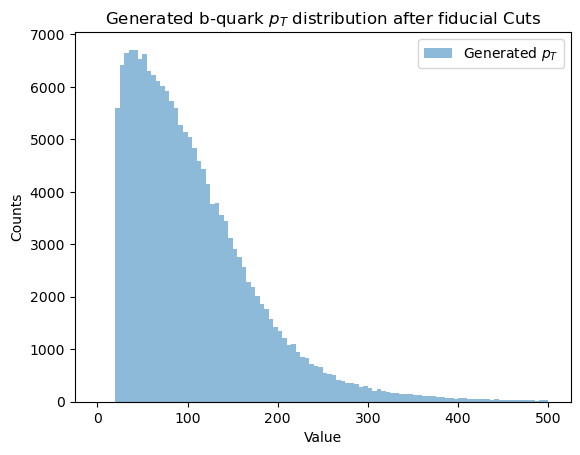

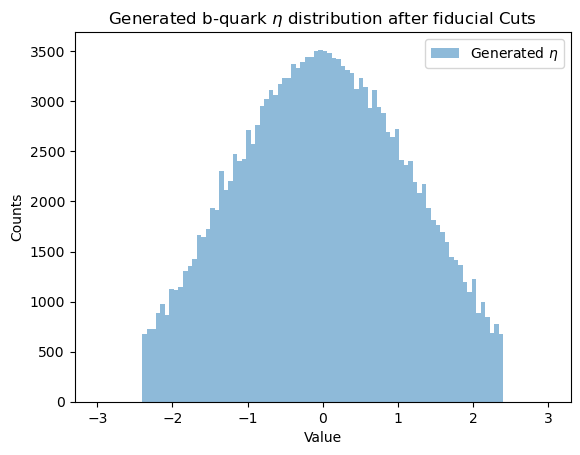


Plotting kinematic distributions before custom cuts...


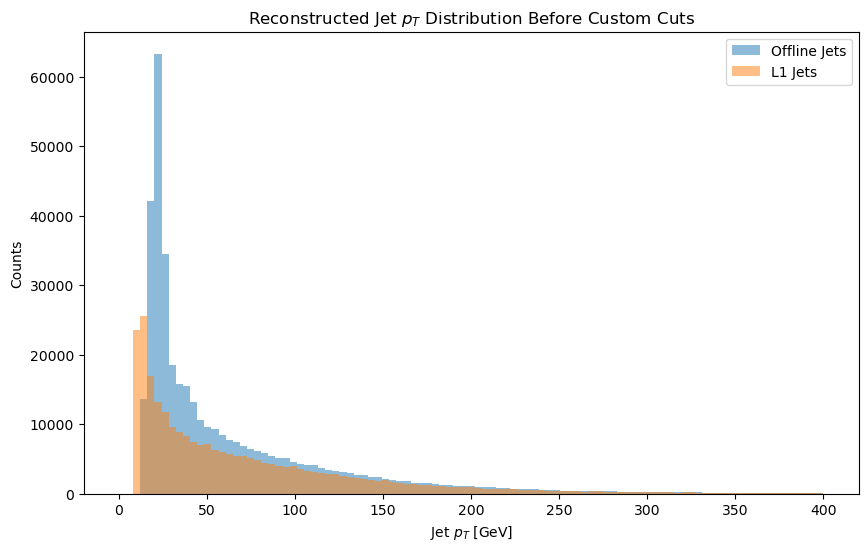

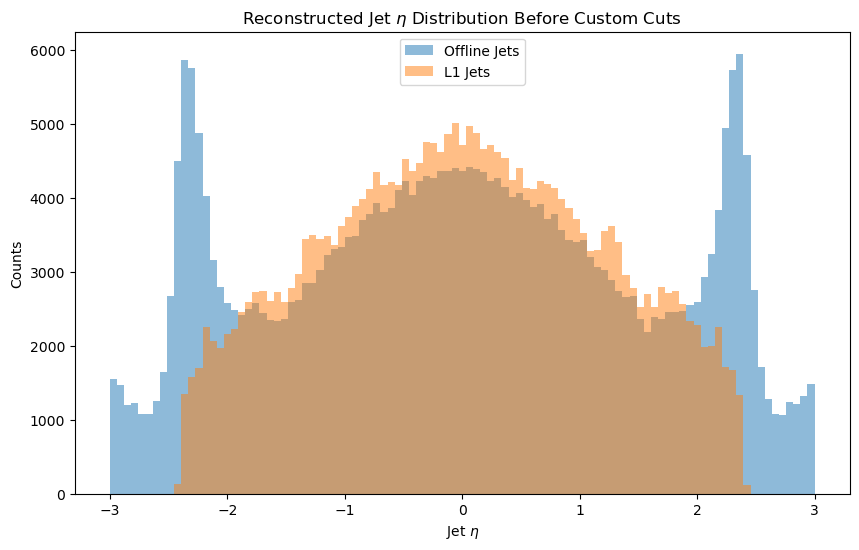

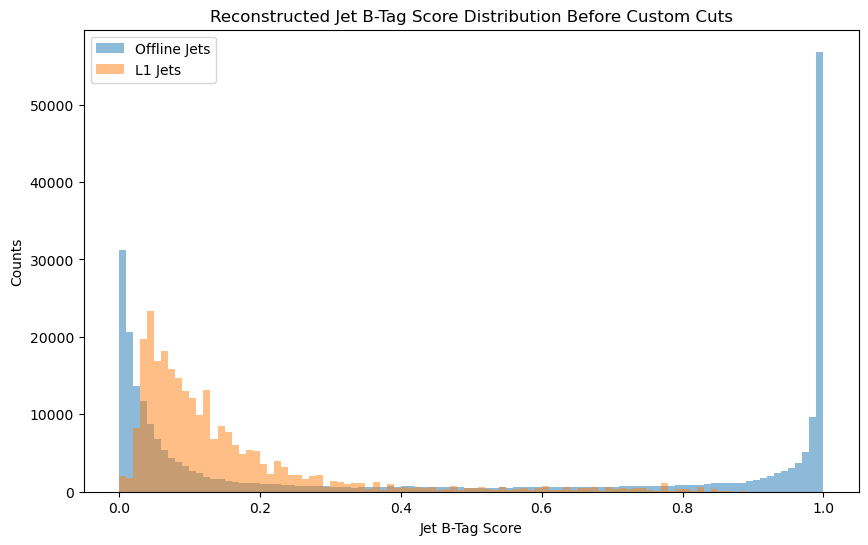


Applying custom cuts for high purity b-jets...

Applying custom pT cut of 20.0 GeV...

Applying custom cuts for btagPNetB...

Plotting kinematic distributions after custom cuts...


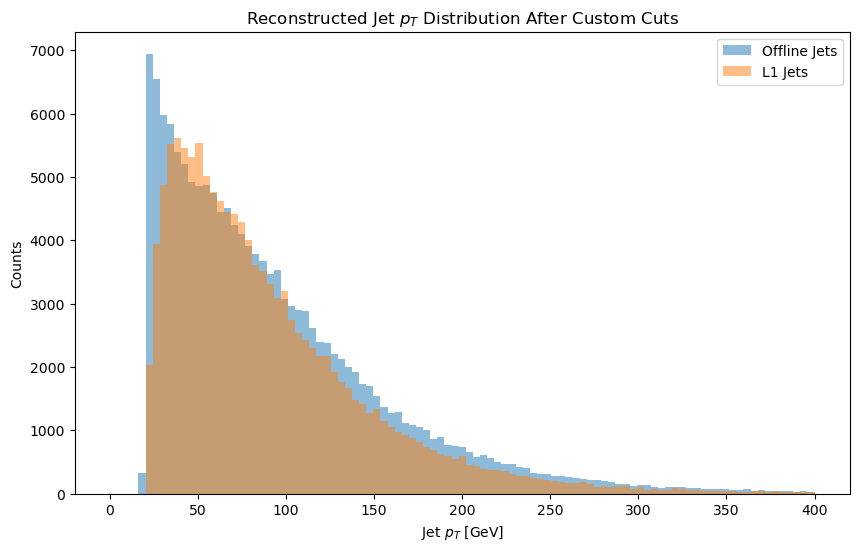

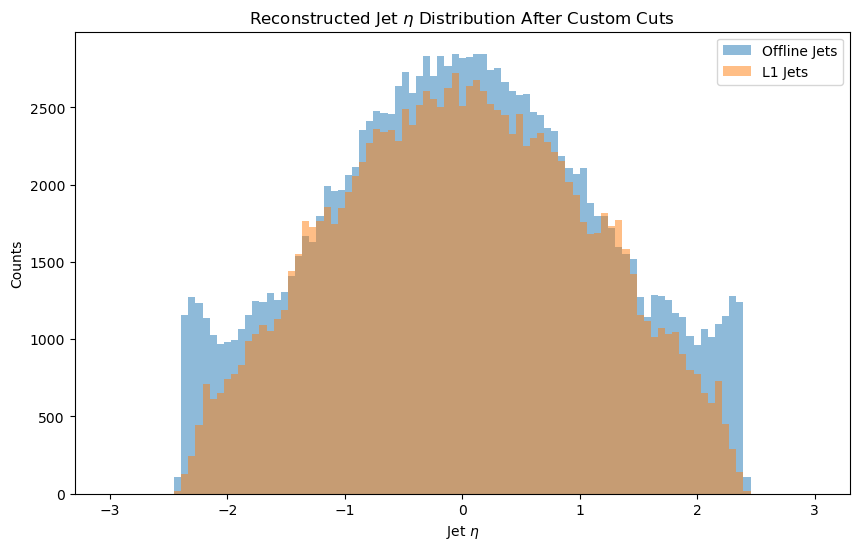

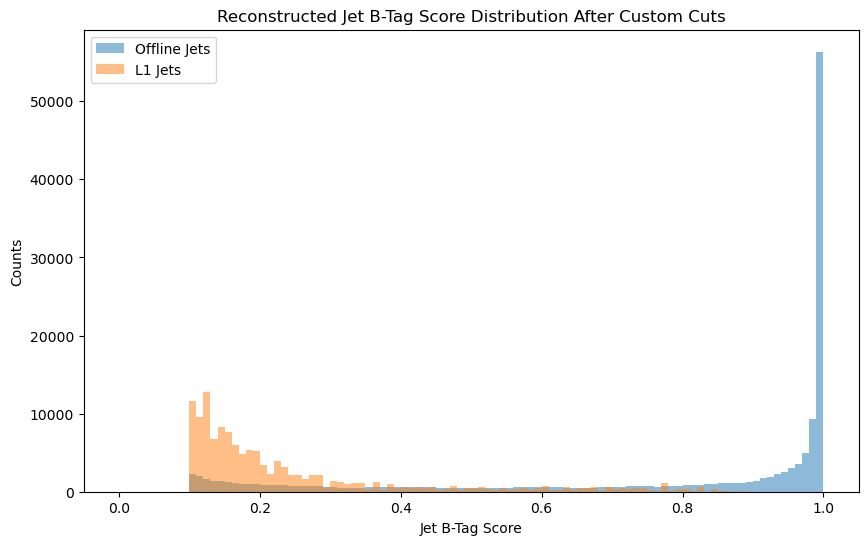


Running analysis...
Plotting reconstruction efficiencies...


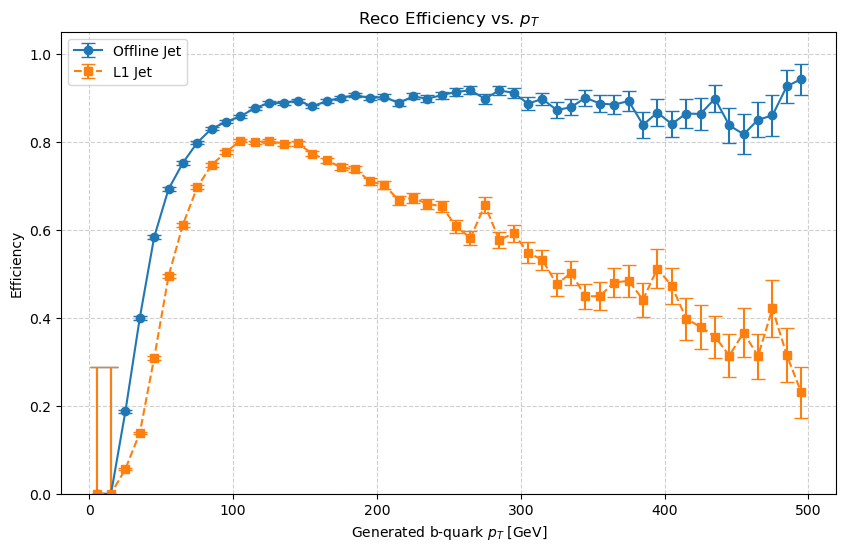

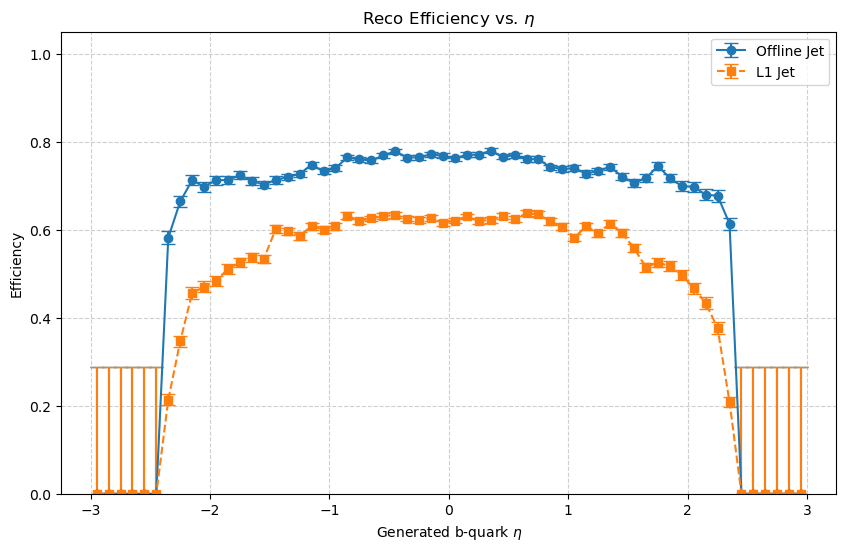

Plotting purity...


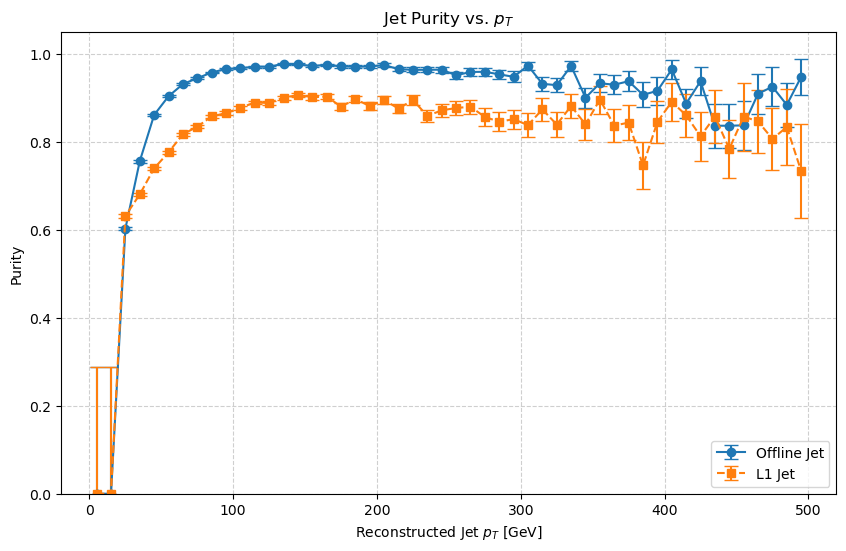

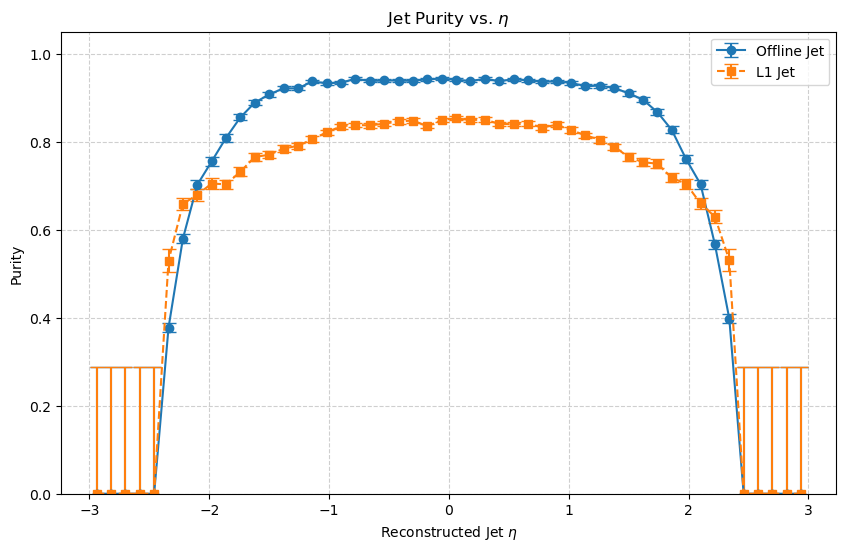

Calculating ROC curves...


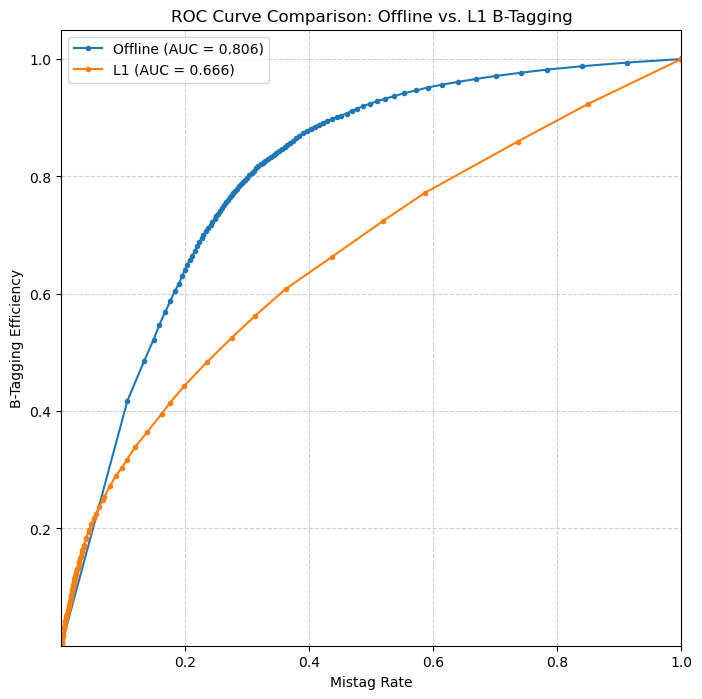


Analysis Complete!


In [2]:
def run_analysis(CONFIG):
    """
    Main function to run the analysis with custom cuts.
    """
    print("Starting analysis with custom cuts...")

    # --- Load and Prepare Data ---
    collections = [
        "GenPart", 
        CONFIG["offline"]["collection_name"], 
        CONFIG["l1"]["collection_name"]
    ]
    events = load_and_prepare_data(
        CONFIG["file_pattern"], 
        CONFIG["tree_name"], 
        collections, 
        CONFIG["max_events"]
    )


    gen_b_quarks = select_gen_b_quarks_from_higgs(events)

    # Fiduciary cuts for gen particles
    print("\nApplying fiducial cuts to generated b-quarks...")

    pt_gen_cut = CONFIG["gen"]["pt_cut"]
    eta_gen_cut = CONFIG["gen"]["eta_cut"]

    gen_b_quarks = gen_b_quarks[(gen_b_quarks.pt > pt_gen_cut) & (abs(gen_b_quarks.eta) < eta_gen_cut)]

    gen_pt = ak.to_numpy(ak.flatten(gen_b_quarks.pt))
    gen_eta = ak.to_numpy(ak.flatten(gen_b_quarks.eta))
    print(f"Number of gen-level b-quarks after fiducial cuts: {len(gen_pt)}")

    plt.hist(gen_pt, bins=100, range=(0, 500), alpha=0.5, label="Generated $p_T$")
    plt.xlabel("Value")
    plt.ylabel("Counts")
    plt.title("Generated b-quark $p_T$ distribution after fiducial Cuts")
    plt.legend()
    plt.show()

    plt.hist(gen_eta, bins=100, range=(-3, 3), alpha=0.5, label="Generated $\\eta$")
    plt.xlabel("Value")
    plt.ylabel("Counts")
    plt.title("Generated b-quark $\\eta$ distribution after fiducial Cuts")
    plt.legend()
    plt.show()


    # --- Get Baseline Reconstructed Collections ---
    reco_jets_offline = events[CONFIG["offline"]["collection_name"]]
    reco_jets_l1 = events[CONFIG["l1"]["collection_name"]]

    print("\nPlotting kinematic distributions before custom cuts...")
    pt_bins = np.linspace(0, 400, 100)
    eta_bins = np.linspace(-3, 3, 100)
    b_bins = np.linspace(0, 1, 101)

    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_offline.pt)), bins=pt_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_l1.pt)), bins=pt_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet $p_T$ [GeV]")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet $p_T$ Distribution Before Custom Cuts")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_offline.eta)), bins=eta_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_l1.eta)), bins=eta_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet $\\eta$")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet $\\eta$ Distribution Before Custom Cuts")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(getattr(reco_jets_offline, CONFIG["offline"]["tagger_name"]))), bins=b_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(getattr(reco_jets_l1, CONFIG["l1"]["tagger_name"]))), bins=b_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet B-Tag Score")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet B-Tag Score Distribution Before Custom Cuts")
    plt.legend()
    plt.show()

    print("\nApplying custom cuts for high purity b-jets...")

    reco_jets_offline = apply_custom_offline_cuts(reco_jets_offline, CONFIG)
    reco_jets_l1 = apply_custom_l1_cuts(reco_jets_l1, CONFIG)

    print("\nPlotting kinematic distributions after custom cuts...")
    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_offline.pt)), bins=pt_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_l1.pt)), bins=pt_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet $p_T$ [GeV]")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet $p_T$ Distribution After Custom Cuts")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_offline.eta)), bins=eta_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(reco_jets_l1.eta)), bins=eta_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet $\\eta$")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet $\\eta$ Distribution After Custom Cuts")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(ak.to_numpy(ak.flatten(getattr(reco_jets_offline, CONFIG["offline"]["tagger_name"]))), bins=b_bins, alpha=0.5, label="Offline Jets")
    plt.hist(ak.to_numpy(ak.flatten(getattr(reco_jets_l1, CONFIG["l1"]["tagger_name"]))), bins=b_bins, alpha=0.5, label="L1 Jets")
    plt.xlabel("Jet B-Tag Score")
    plt.ylabel("Counts")
    plt.title("Reconstructed Jet B-Tag Score Distribution After Custom Cuts")
    plt.legend()
    plt.show()

    print("\nRunning analysis...")

    # --- Efficiency Analysis ---
    b_quarks_is_matched_offline = get_efficiency_mask(gen_b_quarks, reco_jets_offline)
    b_quarks_is_matched_l1 = get_efficiency_mask(gen_b_quarks, reco_jets_l1)

    print("Plotting reconstruction efficiencies...")
    plot_kinematic_comparison(
        bins=np.linspace(0, 500, 51), variable="pt",
        xlabel=r"Generated b-quark $p_T$ [GeV]", title="Reco Efficiency vs. $p_T$",
        gen_particles=gen_b_quarks,
        offline_objects=reco_jets_offline, offline_mask=b_quarks_is_matched_offline,
        l1_objects=reco_jets_l1, l1_mask=b_quarks_is_matched_l1
    )

    plot_kinematic_comparison(
        bins=np.linspace(-3, 3, 61), variable="eta",
        xlabel="Generated b-quark $\\eta$", title="Reco Efficiency vs. $\\eta$",
        gen_particles=gen_b_quarks,
        offline_objects=reco_jets_offline, offline_mask=b_quarks_is_matched_offline,
        l1_objects=reco_jets_l1, l1_mask=b_quarks_is_matched_l1
    )

    # --- Purity Analysis ---
    is_reco_jet_pure_offline = get_purity_mask(gen_b_quarks, reco_jets_offline)
    is_reco_jet_pure_l1 = get_purity_mask(gen_b_quarks, reco_jets_l1)

    print("Plotting purity...")
    plot_kinematic_comparison(
        bins=np.linspace(0, 500, 51), variable="pt",
        xlabel="Reconstructed Jet $p_T$ [GeV]", title="Jet Purity vs. $p_T$",
        gen_particles=gen_b_quarks, # gen_particles is not used for purity plot
        offline_objects=reco_jets_offline, offline_mask=is_reco_jet_pure_offline,
        l1_objects=reco_jets_l1, l1_mask=is_reco_jet_pure_l1,
        is_purity_plot=True
    )

    plot_kinematic_comparison(
        bins=np.linspace(-3, 3, 51), variable="eta",
        xlabel="Reconstructed Jet $\\eta$", title="Jet Purity vs. $\\eta$",
        gen_particles=gen_b_quarks, # gen_particles is not used for purity plot
        offline_objects=reco_jets_offline, offline_mask=is_reco_jet_pure_offline,
        l1_objects=reco_jets_l1, l1_mask=is_reco_jet_pure_l1,
        is_purity_plot=True
    )

    # # --- ROC Curve Analysis ---
    print("Calculating ROC curves...")

    roc_offline = calculate_roc_points(
        reco_jets_offline, 
        is_reco_jet_pure_offline, 
        CONFIG["offline"]["tagger_name"]
    )

    roc_l1 = calculate_roc_points(
        reco_jets_l1, 
        is_reco_jet_pure_l1, 
        CONFIG["l1"]["tagger_name"]
    )

    plot_roc_comparison([
        ("Offline", roc_offline),
        ("L1", roc_l1)
    ])

    print("\nAnalysis Complete!")
    return events



with open("hh-bbbb-obj-config.json", "r") as config_file:
    CONFIG = json.load(config_file)

events = run_analysis(CONFIG)

Selecting gen-level b-quarks...
Found 200000 b-quarks from Higgs decays.

Plotting Top-N Jet Efficiencies for N = 4...


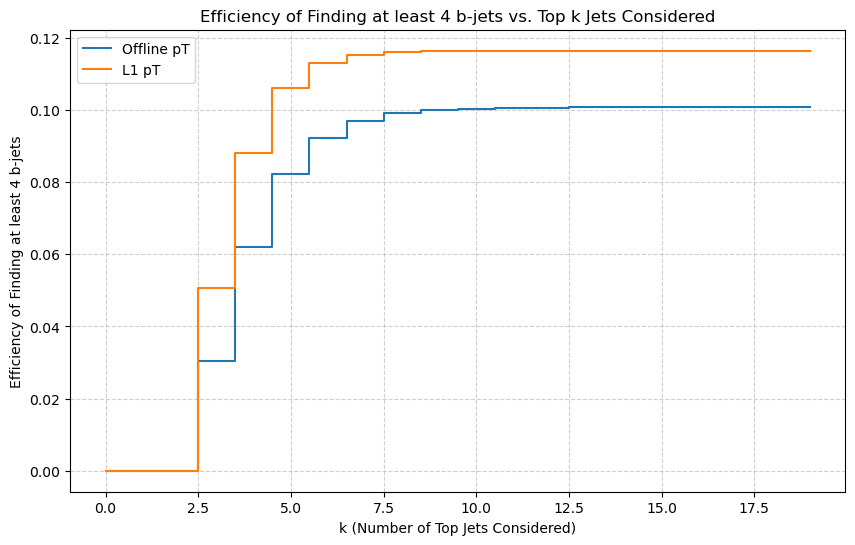

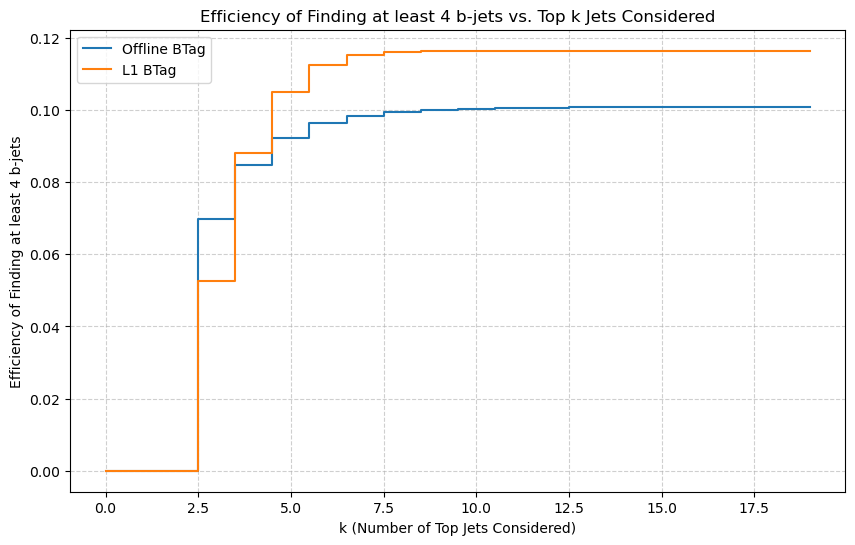

In [ ]:
def gen_b_masks(events):
    """
    For each event, checks if at least n b-jets are found within the top k jets.
    Returns a boolean mask per event.
    """

    gen_b_from_higgs = select_gen_b_quarks_from_higgs(events)

    pt_cut_gen = CONFIG["gen"]["pt_cut"]
    eta_cut_gen = CONFIG["gen"]["eta_cut"]

    gen_b_from_higgs = gen_b_from_higgs[(gen_b_from_higgs.pt > pt_cut_gen) & (abs(gen_b_from_higgs.eta) < eta_cut_gen)]

    base_jets_offline = events[CONFIG["offline"]["collection_name"]]
    base_l1_jets = events[CONFIG["l1"]["collection_name"]]

    pt_ordered_offline = base_jets_offline[ak.argsort(base_jets_offline.vector.pt, ascending=False)]
    pt_ordered_l1 = base_l1_jets[ak.argsort(base_l1_jets.vector.pt, ascending=False)]

    b_score_ordered_offline = base_jets_offline[ak.argsort(getattr(base_jets_offline, CONFIG["offline"]["tagger_name"]), ascending=False)]
    b_score_ordered_l1 = base_l1_jets[ak.argsort(getattr(base_l1_jets, CONFIG["l1"]["tagger_name"]), ascending=False)]

    true_pt_offline_mask = get_purity_mask(gen_b_from_higgs, pt_ordered_offline)
    true_pt_l1_mask = get_purity_mask(gen_b_from_higgs, pt_ordered_l1)

    true_btag_offline_mask = get_purity_mask(gen_b_from_higgs, b_score_ordered_offline)
    true_btag_l1_mask = get_purity_mask(gen_b_from_higgs, b_score_ordered_l1)

    pt_ordered_offline = pt_ordered_offline[true_pt_offline_mask]
    pt_ordered_l1 = pt_ordered_l1[true_pt_l1_mask]

    b_score_ordered_offline = b_score_ordered_offline[true_btag_offline_mask]
    b_score_ordered_l1 = b_score_ordered_l1[true_btag_l1_mask]

    return {"gen_b_from_higgs": gen_b_from_higgs,
            "ordered": (pt_ordered_offline, pt_ordered_l1, b_score_ordered_offline, b_score_ordered_l1), 
            "masks": (true_pt_offline_mask, true_pt_l1_mask, true_btag_offline_mask, true_btag_l1_mask)
            }

def find_n_jets_rolling(gen_b_from_higgs, ordered, masks, n, k):
    top_k_pt_offline = ordered[0][:, :k]
    top_k_pt_l1 = ordered[1][:, :k]

    top_k_btag_offline = ordered[2][:, :k]
    top_k_btag_l1 = ordered[3][:, :k]

    eff_pt_offline = ak.sum(ak.num(top_k_pt_offline)) / ak.sum(ak.num(gen_b_from_higgs))
    eff_pt_l1 = ak.sum(ak.num(top_k_pt_l1)) / ak.sum(ak.num(gen_b_from_higgs))

    eff_btag_offline = ak.sum(ak.num(top_k_btag_offline)) / ak.sum(ak.num(gen_b_from_higgs))
    eff_btag_l1 = ak.sum(ak.num(top_k_btag_l1)) / ak.sum(ak.num(gen_b_from_higgs))

    true_pt_offline_mask = masks[0][:, :k]
    more_than_n_mask_offline = ak.sum(true_pt_offline_mask, axis=1) >= n
    more_than_n_efficiency_offline = ak.sum(more_than_n_mask_offline) / len(ak.flatten(gen_b_from_higgs))

    true_pt_l1_mask = masks[1][:, :k]
    more_than_n_mask_l1 = ak.sum(true_pt_l1_mask, axis=1) >= n
    more_than_n_efficiency_l1 = ak.sum(more_than_n_mask_l1) / len(ak.flatten(gen_b_from_higgs))

    true_btag_offline_mask = masks[2][:, :k]
    more_than_n_b_mask_offline = ak.sum(true_btag_offline_mask, axis=1) >= n
    more_than_n_b_efficiency_offline = ak.sum(more_than_n_b_mask_offline) / len(ak.flatten(gen_b_from_higgs))

    true_btag_l1_mask = masks[3][:, :k]
    more_than_n_b_mask_l1 = ak.sum(true_btag_l1_mask, axis=1) >= n
    more_than_n_b_efficiency_l1 = ak.sum(more_than_n_b_mask_l1) / len(ak.flatten(gen_b_from_higgs))

    return {"more_than_n_pt": (more_than_n_efficiency_offline, more_than_n_efficiency_l1),
            "more_than_n_b": (more_than_n_b_efficiency_offline, more_than_n_b_efficiency_l1),
            "pt_eff": (eff_pt_offline, eff_pt_l1),
            "btag_eff": (eff_btag_offline, eff_btag_l1)
           }


more_than_n_eff_pt_offline = []
more_than_n_eff_pt_l1 = []

more_than_n_eff_btag_offline = []
more_than_n_eff_btag_l1 = []

ordered_and_masks = gen_b_masks(events)
gen_b_from_higgs = ordered_and_masks["gen_b_from_higgs"]
ordered = ordered_and_masks["ordered"]
masks = ordered_and_masks["masks"]

n = 4

for k in range(20):
    out_dict = find_n_jets_rolling(gen_b_from_higgs, ordered, masks, n, k+1)

    more_than_n_efficiency_offline, more_than_n_efficiency_l1 = out_dict["more_than_n_pt"]
    more_than_n_eff_pt_offline.append(more_than_n_efficiency_offline)
    more_than_n_eff_pt_l1.append(more_than_n_efficiency_l1)

    more_than_n_efficiency_offline, more_than_n_efficiency_l1 = out_dict["more_than_n_b"]
    more_than_n_eff_btag_offline.append(more_than_n_efficiency_offline)
    more_than_n_eff_btag_l1.append(more_than_n_efficiency_l1)

print(f"\nPlotting Top-N Jet Efficiencies for N = {n}...")
plt.figure(figsize=(10, 6))
plt.step(range(20), more_than_n_eff_pt_offline, where='mid', label='Offline pT')
plt.step(range(20), more_than_n_eff_pt_l1, where='mid', label='L1 pT')
plt.xlabel("k (Number of Top Jets Considered)")
plt.ylabel(f"Efficiency of Finding at least {n} b-jets")
plt.title(f"Efficiency of Finding at least {n} b-jets vs. Top k Jets Considered")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.step(range(20), more_than_n_eff_btag_offline, where='mid', label='Offline BTag')
plt.step(range(20), more_than_n_eff_btag_l1, where='mid', label='L1 BTag')
plt.xlabel("k (Number of Top Jets Considered)")
plt.ylabel(f"Efficiency of Finding at least {n} b-jets")
plt.title(f"Efficiency of Finding at least {n} b-jets vs. Top k Jets Considered")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()